# IFT6135 -  Practical Assignment  One

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pickle
%matplotlib inline

# Data Preparation 

#### Reading data and preparing the test, train and validation sets

In [3]:
input_size = 784
output_size = 10

In [36]:
class NN:
    ### __init__ Function to load the data and split the train set to train and validation sets
    def __init__(self, mode, datapath=None, hidden_dims=None, hparams={}, model_path=None):
        if mode=='train': assert (hidden_dims is not None) and bool(hparams)
        if mode=='test': assert model_path is not None
        self.mode = mode
        self.model_path = model_path
        self.lr = hparams.get('lr')
        self.weight_decay = hparams.get('weight_decay')
        self.num_epochs = hparams.get('num_epochs')
        self.Params = {}
        data = np.load(datapath)
        # Train data
        self.X_train = data['x_train'][:48000].reshape(48000, 784)
        self.y_train = data['y_train'][:48000]
        # Validation data
        self.X_valid = data['x_train'][48000:].reshape(12000, 784)
        self.y_valid = data['y_train'][48000:]
        self.X_test = data['x_test'].reshape(10000, 784)
        self.y_test = data['y_test']
        if (mode == 'train'):
            self.hidden_dims=(512,512)
            self.init_method = hparams['init_method']
            self.initialize_weights(hidden_dims)
        elif(mode == 'test'):
            with open(model_path,'rb') as f:
                 self.Params = pickle.load(f)
    
    
    # Initialize the fucntion in three different ways : 1. Normal 2. Glorot 3. Zero
    def initialize_weights(self, dims):
        n_hidden = len(dims)
        num_nodes = [input_size] + list(dims) + [output_size]
        print('Initialization Method: %s' % self.init_method)
        print('--------------\n')
        for i in range(n_hidden + 1):
            self.Params['b%d'%(i+1)] = np.zeros(num_nodes[i+1])
            if self.init_method == 'Normal':
                self.Params['W%d'%(i+1)] = np.random.normal(0, 1,
                                                            (num_nodes[i+1], num_nodes[i]))
            elif self.init_method == 'Glorot':
                D_Glorot = np.sqrt(6.0 / (num_nodes[i+1] + num_nodes[i]))
                self.Params['W%d'%(i+1)] = np.random.uniform(-D_Glorot, D_Glorot,
                                                            (num_nodes[i+1], num_nodes[i]))
            elif self.init_method == 'Zeros':
                self.Params['W%d'%(i+1)] = np.zeros((num_nodes[i+1], num_nodes[i]))
                
            else:
                raise ValueError('Invalid initialization type: %s' % self.init_method)
    
    # Forward propagation
    def forward(self, x):
        N = x.shape[0]
        n_hidden = int(len(self.Params.keys()) / 2)
        h_cache_list = []
        a_cache_list = []
        h = x
        for i in range(n_hidden):
            h, h_cache = self.fc_forward(h, self.Params['W%d'%(i+1)], self.Params['b%d'%(i+1)])
            h_cache_list.append(h_cache)
            if i != (n_hidden-1):
                h, a_cache = self.relu_forward(h)
                a_cache_list.append(a_cache)
        scores = h
        cache = (N, n_hidden, a_cache_list, h_cache_list)
        return scores, cache
    
    # Backward function
    def backward(self, dloss, cache):
        (N, n_hidden, a_cache_list, h_cache_list) = cache
        dx = dloss
        grads = {}
        for i in range(n_hidden, 0, -1):
            dx, dW, db = self.fc_backward(dx, h_cache_list[i-1])
            grads['W%d'%i] = (dW / N) + (self.weight_decay * self.Params['W%d'%i])
            grads['b%d'%i] = (db / N)
            if i != 1:
                dx = self.relu_backward(dx, a_cache_list[i-2])
        return grads
        
    # Computes the forward pass for an affine (fully-connected) layer.
    def fc_forward(self, x, w, b):        
        out = np.dot(x, w.T) + b
        cache = (x, w, b, out)
        return out, cache
    
    # Computes the backward pass for an affine (fully-connected) layer.
    def fc_backward(self, dupstream, cache):        
        (x, w, b, out) = cache
        dx = np.dot(dupstream, w)
        dw = np.dot(dupstream.T, x)
        db = dupstream.sum(axis=0)
        return dx, dw, db
    
    ### Activation function
    def relu_forward(self, x):        
        return np.maximum(0, x), x
    
    def relu_backward(self, dupstream, cache):        
        return ((cache > 0) * dupstream)  
    
    # The function to update parameters    
    def update(self, grads):
        for param, grad in grads.items():
                self.Params[param] -= self.lr * grad
    
    ### Calculate Softmax and loss using cross entropy
    def softmax_loss(self, scores, label):
        sh_log = scores - np.max(scores, axis=1, keepdims=True)
        Z = np.sum(np.exp(sh_log), axis=1, keepdims=True)
        softmax = sh_log - np.log(Z)
        probs = np.exp(softmax)
        dim = scores.shape[0]
        loss = -np.sum(softmax[np.arange(dim), label]) / dim
        x = probs.copy()
        x[np.arange(dim), label] -= 1
        x /= dim
        return loss, x
    
    # Train function
    def train(self, mb_size=100):
        train_loss_hist = []
        val_loss_hist = []
        train_accuracies = []
        val_accuracies = []
        avg_loss = 0
        for ep in range(self.num_epochs):
            train_loss_epoch = 0
            train_data_size = 0
            correct_pred = 0 
            batch_count = np.ceil(self.X_train.shape[0] / mb_size).astype('int')
            for i in range(batch_count):
                xi = self.X_train[i*mb_size:(i+1)*mb_size]
                yi = self.y_train[i*mb_size:(i+1)*mb_size]
                scores, cache = self.forward(xi)
                pred_train = np.argmax(scores, axis=1)
                train_loss, dloss = self.softmax_loss(scores, yi)
                correct_pred += (pred_train == yi).sum()
                grads = self.backward(dloss, cache)
                self.update(grads)
                train_loss_epoch += train_loss * len(yi)
                train_data_size += len(yi)
                     
            scores_val,_ = self.forward(self.X_valid)
            pred_val = np.argmax(scores_val, axis=1)
            val_loss, _ = self.softmax_loss(scores_val, self.y_valid)
                
            train_loss_hist.append(train_loss_epoch / train_data_size)
            val_loss_hist.append(val_loss)
            train_acc = correct_pred / train_data_size 
            val_acc = (pred_val == self.y_valid).mean()
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            print('Epoch %d' % ep)
            print('Train: Loss: %.4f, Accuracy %.4f' % (train_loss_epoch / train_data_size, train_acc))
            print('Validation: Loss: %.4f, Accuracy %.4f\n' % (val_loss, val_acc))

        train_history = {'train_loss_hist':train_loss_hist,
                         'val_loss_hist':val_loss_hist,
                         'train_accuracies':train_accuracies,
                         'val_accuracies':val_accuracies}
        if self.model_path is not None:
            with open(self.model_path, 'wb') as f:
                pickle.dump(self.Params, f)
        return train_history
    
    # Test function 
    def test(self, x):
        scores,_ = self.forward(x)
        return scores

### Helper Functions

In [18]:
def historyPlt(train_history):
    train_losses = train_history['train_loss_hist']
    train_accuracies = train_history['train_accuracies']
    valid_losses = train_history['val_loss_hist']
    valid_accuracies = train_history['val_accuracies']
    
    # Plotting the loss accuracy
    plt.figure(figsize=(12, 4))
    axis = plt.subplot(1, 2, 1)
    axis.plot(range(1, len(train_losses)+1), train_losses, label='train', color = 'blue', c ='b', linewidth=3.0)
    axis.plot(range(1, len(valid_losses)+1), valid_losses, label='valid', color = 'red', c ='b', linewidth=3.0)
    axis.legend()
    axis.set_ylabel('Loss')
    axis.set_xlabel('Epochs')
    
    axis = plt.subplot(1, 2, 2)
    axis.plot(range(1, len(train_accuracies)+1), train_accuracies, label='train', color = 'blue', c ='b', linewidth=3.0)
    axis.plot(range(1, len(valid_accuracies)+1), valid_accuracies, label='valid', color = 'red', c ='b', linewidth=3.0)
    axis.legend()
    axis.set_ylabel('Accuracy')
    axis.set_xlabel('Epochs')    
    

def accuracy(scores, labels):
    preds = np.argmax(scores, axis=1)
    accuracy = (preds == labels).mean()
    return accuracy

### 1 .Train the model for 10 epochs 3 using the initialization methods above and record the average loss measured on the training data at the end of each epoch (10 values for each setup).

### 2. Compare the three setups by plotting the losses against the training time (epoch) and comment on the result.

#### For this part we trian the model using 3 different initialization approach. 
#### 1.1. Initialization using Normal method

In [16]:
# Initiate hyperparameters
hparams = {'init_method': 'Normal',
           'lr': 1e-1,
           'weight_decay': 0,
           'num_epochs': 10}

# Initialize NN object
nn = NN(mode='train', datapath='./mnist.npz', hidden_dims=(512, 512), hparams=hparams,
        model_path='Params.pkl')

# Start training
train_history_normal = nn.train()
print('Training done!')

Initialization Method: Normal
--------------

Epoch 0
Train: Loss: 766436245291446901776873926236796245558427648.0000, Accuracy 0.1107
Validation: Loss: 2647632.1122, Accuracy 0.1061

Epoch 1
Train: Loss: 2.3023, Accuracy 0.1140
Validation: Loss: 2647632.1121, Accuracy 0.1061

Epoch 2
Train: Loss: 2.3022, Accuracy 0.1140
Validation: Loss: 2647632.1121, Accuracy 0.1061

Epoch 3
Train: Loss: 2.3021, Accuracy 0.1140
Validation: Loss: 2647632.1120, Accuracy 0.1061

Epoch 4
Train: Loss: 2.3020, Accuracy 0.1140
Validation: Loss: 2647632.1119, Accuracy 0.1061

Epoch 5
Train: Loss: 2.3019, Accuracy 0.1140
Validation: Loss: 2647632.1119, Accuracy 0.1061

Epoch 6
Train: Loss: 2.3018, Accuracy 0.1140
Validation: Loss: 2647632.1119, Accuracy 0.1061

Epoch 7
Train: Loss: 2.3017, Accuracy 0.1140
Validation: Loss: 2647632.1118, Accuracy 0.1061

Epoch 8
Train: Loss: 2.3017, Accuracy 0.1140
Validation: Loss: 2647632.1118, Accuracy 0.1061

Epoch 9
Train: Loss: 2.3016, Accuracy 0.1140
Validation: Loss: 2

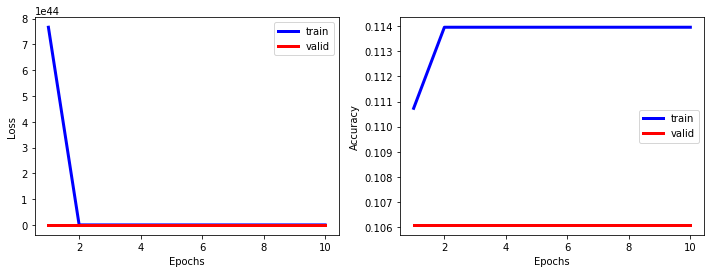

In [19]:
historyPlt(train_history_normal)

####  1.2. Initialization using Glorot method

In [5]:
# Initiate hyperparameters
hparams = {'init_method': 'Glorot',
           'lr': 1e-1,
           'weight_decay': 0,
           'num_epochs': 10}

# Initialize NN object
nn = NN(mode='train', datapath='./mnist.npz', hidden_dims=(512, 512), hparams=hparams,
        model_path='Params.pkl')

# Start training
train_history_glorot = nn.train()
print('Training done!')

Initialization Method: Glorot
--------------

Epoch 0
Train: Loss: 3.3376, Accuracy 0.8751
Validation: Loss: 0.8212, Accuracy 0.9147

Epoch 1
Train: Loss: 0.4210, Accuracy 0.9468
Validation: Loss: 0.5856, Accuracy 0.9292

Epoch 2
Train: Loss: 0.2038, Accuracy 0.9662
Validation: Loss: 0.5339, Accuracy 0.9343

Epoch 3
Train: Loss: 0.1037, Accuracy 0.9809
Validation: Loss: 0.4937, Accuracy 0.9378

Epoch 4
Train: Loss: 0.0559, Accuracy 0.9884
Validation: Loss: 0.4795, Accuracy 0.9387

Epoch 5
Train: Loss: 0.0304, Accuracy 0.9940
Validation: Loss: 0.4676, Accuracy 0.9393

Epoch 6
Train: Loss: 0.0163, Accuracy 0.9974
Validation: Loss: 0.4618, Accuracy 0.9413

Epoch 7
Train: Loss: 0.0093, Accuracy 0.9987
Validation: Loss: 0.4565, Accuracy 0.9433

Epoch 8
Train: Loss: 0.0055, Accuracy 0.9995
Validation: Loss: 0.4527, Accuracy 0.9440

Epoch 9
Train: Loss: 0.0037, Accuracy 0.9998
Validation: Loss: 0.4502, Accuracy 0.9452

Training done!


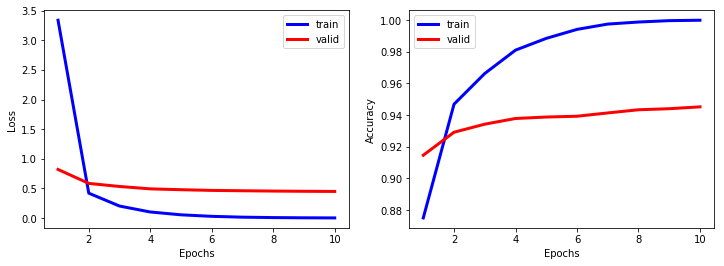

In [52]:
historyPlt(train_history_glorot)

#### 1.3. Initialization using Zero method

In [8]:
# Initiate hyperparameters
hparams = {'init_method': 'Zeros',
           'lr': 1e-1,
           'weight_decay': 0,
           'num_epochs': 10}

# Initialize NN object
nn = NN(mode='train', datapath='./mnist.npz', hidden_dims=(512, 512), hparams=hparams,
        model_path='Params.pkl')

# Start training
train_history_zero = nn.train()
print('Training done!')

Initialization Method: Zeros
--------------

Epoch 0
Train: Loss: 2.3025, Accuracy 0.1136
Validation: Loss: 2.3025, Accuracy 0.1060

Epoch 1
Train: Loss: 2.3024, Accuracy 0.1140
Validation: Loss: 2.3024, Accuracy 0.1060

Epoch 2
Train: Loss: 2.3022, Accuracy 0.1140
Validation: Loss: 2.3023, Accuracy 0.1060

Epoch 3
Train: Loss: 2.3021, Accuracy 0.1140
Validation: Loss: 2.3023, Accuracy 0.1060

Epoch 4
Train: Loss: 2.3020, Accuracy 0.1140
Validation: Loss: 2.3022, Accuracy 0.1060

Epoch 5
Train: Loss: 2.3019, Accuracy 0.1140
Validation: Loss: 2.3022, Accuracy 0.1060

Epoch 6
Train: Loss: 2.3018, Accuracy 0.1140
Validation: Loss: 2.3021, Accuracy 0.1060

Epoch 7
Train: Loss: 2.3017, Accuracy 0.1140
Validation: Loss: 2.3021, Accuracy 0.1060

Epoch 8
Train: Loss: 2.3017, Accuracy 0.1140
Validation: Loss: 2.3021, Accuracy 0.1060

Epoch 9
Train: Loss: 2.3016, Accuracy 0.1140
Validation: Loss: 2.3020, Accuracy 0.1060

Training done!


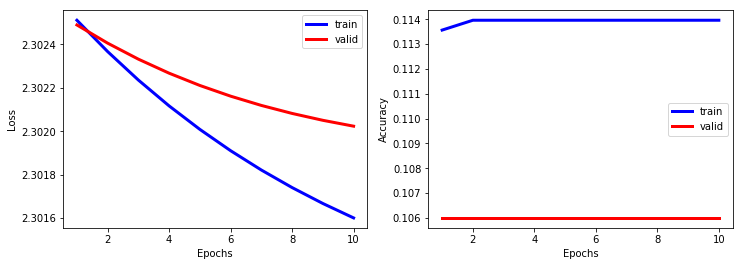

In [53]:
historyPlt(train_history_zero)

## Hyperparameter Search From now on, use the Glorot initialization method.

### 1. Find out a combination of hyper-parameters (model architecture, learning rate, nonlinearity, etc.) such that the average accuracy rate on the validation set (r(valid)) is at least 97%.
### 2. Report the hyper-parameters you tried and the corresponding r(valid).

### Optimal Hyperparameter Search

In [67]:
# # Initiate hyperparameters
# hparams = {'init_method': 'Glorot',
#           'num_epochs': 3}

# for i in range(100):
#     lr = 10 ** np.random.uniform(-2, 0)
#     weight_decay = 10 ** np.random.uniform(-5, 0)
    
#     hparams['lr'] = lr
#     hparams['weight_decay'] = weight_decay
#     print('lr: %.6f'%lr)
#     print('weight_decay: %.6f'%weight_decay)
#     # Initialize NN object
#     nn = NN((512,512), mode='train', hparams=hparams, datapath='./mnist.npz')
    
#     # Start training
#     train_history = nn.train()


# print('Training done!')

##  Solution 1 : Hyperparameters Report :

## The case with at least 97%  on accuracy rate on the validation set.


In [25]:
# Initiate hyperparameters
hparams = {'init_method': 'Glorot',
           'lr': 0.14,
           'weight_decay': 1e-3,
           'num_epochs': 10}

# Initialize NN object
nn = NN(mode='train', datapath='./mnist.npz', hidden_dims=(600, 250), hparams=hparams,
        model_path='Params.pkl')

# Start training
train_history = nn.train()
print('Training done!')

Initialization Method: Glorot
--------------

Epoch 0
Train: Loss: 5.6846, Accuracy 0.8661
Validation: Loss: 0.2605, Accuracy 0.9229

Epoch 1
Train: Loss: 0.1918, Accuracy 0.9417
Validation: Loss: 0.1864, Accuracy 0.9453

Epoch 2
Train: Loss: 0.1393, Accuracy 0.9574
Validation: Loss: 0.1550, Accuracy 0.9543

Epoch 3
Train: Loss: 0.1131, Accuracy 0.9663
Validation: Loss: 0.1372, Accuracy 0.9593

Epoch 4
Train: Loss: 0.0964, Accuracy 0.9723
Validation: Loss: 0.1254, Accuracy 0.9617

Epoch 5
Train: Loss: 0.0849, Accuracy 0.9766
Validation: Loss: 0.1175, Accuracy 0.9639

Epoch 6
Train: Loss: 0.0767, Accuracy 0.9798
Validation: Loss: 0.1105, Accuracy 0.9658

Epoch 7
Train: Loss: 0.0714, Accuracy 0.9817
Validation: Loss: 0.1062, Accuracy 0.9678

Epoch 8
Train: Loss: 0.0671, Accuracy 0.9834
Validation: Loss: 0.1028, Accuracy 0.9700

Epoch 9
Train: Loss: 0.0642, Accuracy 0.9844
Validation: Loss: 0.1003, Accuracy 0.9712

Training done!


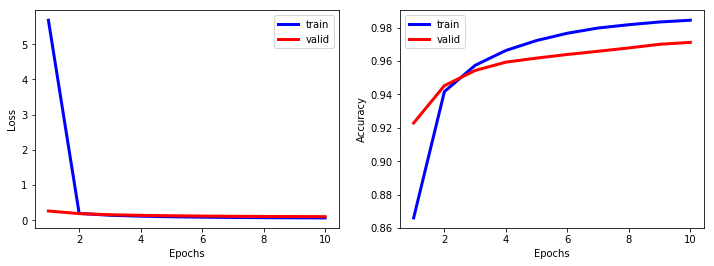

In [54]:
historyPlt(train_history)

##  Solution 2 :  Hyperparameters Report :

In [ ]:
For this question, we trained the model with the following parameters:
     Initialization method : Normal(mean = 0, sd = 0.001) 
     learning rate : 0.14
     batch size : 50
     number of epochs : 10
     weight_decay : 0
     number of neurons for l1, l2 : 512 * 512
     Non linearity : ReLU
     Optimizer : SGD

In [33]:
# Initiate hyperparameters
hparams = {'init_method': 'Normal',
           'lr': 1e-1,
           'weight_decay': 0,
           'num_epochs': 10}

# Initialize NN object
nn = NN(mode='train', datapath='./mnist.npz', hidden_dims=(512, 512), hparams=hparams,
        model_path='Params.pkl')

# Start training
train_history_normal_sd_001 = nn.train()
print('Training done!')

Initialization Method: Normal
--------------

Epoch 0
Train: Loss: 1.1431, Accuracy 0.6514
Validation: Loss: 0.3999, Accuracy 0.8858

Epoch 1
Train: Loss: 0.2952, Accuracy 0.9145
Validation: Loss: 0.2320, Accuracy 0.9355

Epoch 2
Train: Loss: 0.1824, Accuracy 0.9470
Validation: Loss: 0.1615, Accuracy 0.9554

Epoch 3
Train: Loss: 0.1302, Accuracy 0.9621
Validation: Loss: 0.1291, Accuracy 0.9626

Epoch 4
Train: Loss: 0.0998, Accuracy 0.9718
Validation: Loss: 0.1132, Accuracy 0.9669

Epoch 5
Train: Loss: 0.0793, Accuracy 0.9776
Validation: Loss: 0.1051, Accuracy 0.9690

Epoch 6
Train: Loss: 0.0639, Accuracy 0.9825
Validation: Loss: 0.0996, Accuracy 0.9713

Epoch 7
Train: Loss: 0.0519, Accuracy 0.9861
Validation: Loss: 0.0966, Accuracy 0.9725

Epoch 8
Train: Loss: 0.0424, Accuracy 0.9892
Validation: Loss: 0.0956, Accuracy 0.9726

Epoch 9
Train: Loss: 0.0344, Accuracy 0.9918
Validation: Loss: 0.0933, Accuracy 0.9738

Training done!


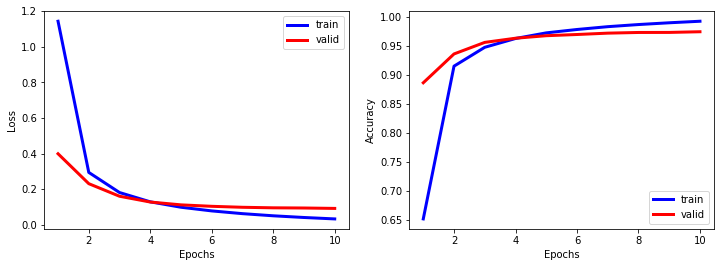

In [34]:
historyPlt(train_history_normal_sd_001)